In [176]:
using RxInfer, Distributions, StableRNGs, Plots, Flux, CCMP

In [180]:
function generate_data(f, g, n; seed = 123, x_i_min = -20.0, w_i_min = 20.0, noise = 3000.0, real_x_τ = 0.1, real_w_τ = 1.0)

    rng = StableRNG(seed)

    real_x = Vector{Float64}(undef, n)
    real_w = Vector{Float64}(undef, n)
    real_f = Vector{Float64}(undef, n)
    real_g = Vector{Float64}(undef, n)
    real_y = Vector{Float64}(undef, n)

    for i in 1:n
        real_x[i] = rand(rng, Normal(x_i_min, sqrt(1.0 / real_x_τ)))
        real_w[i] = rand(rng, Normal(w_i_min, sqrt(1.0 / real_w_τ)))
        real_f[i] = f(real_x[i], real_w[i])
        real_g[i] = g(real_f[i])
        real_y[i] = rand(rng, Normal(real_g[i], sqrt(noise)))

        x_i_min = real_x[i]
        w_i_min = real_w[i]
    end
    
    return real_x, real_w, real_f, real_g, real_y
end

generate_data (generic function with 1 method)

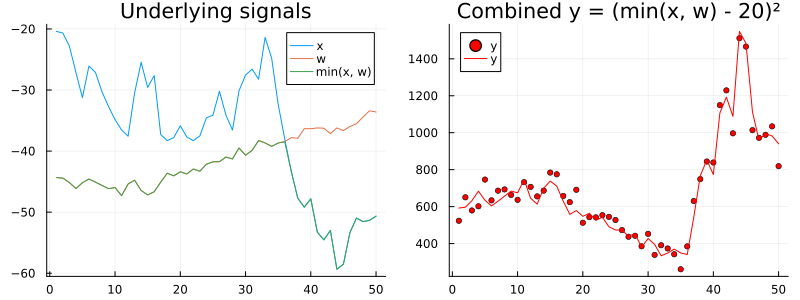

In [181]:
n = 50
ref_point = -20

x_i_min, w_i_min = -20, -45
real_x, real_w, real_f, real_g, real_y = generate_data(min, (x) -> (x - ref_point)^2 , n, x_i_min = x_i_min, w_i_min = w_i_min);

pl = plot(title = "Underlying signals")
pl = plot!(pl, real_x, label = "x")
pl = plot!(pl, real_w, label = "w")
pl = plot!(pl, real_f, label = "min(x, w)")

pr = plot(title = "Combined y = (min(x, w) - $(abs(ref_point)))²")
pr = scatter!(pr, real_y, ms = 3, color = :red, label = "y")
pr = plot!(pr, real_g, ms = 3, color = :red, label = "y")

plot(pl, pr, size = (800, 300))

In [182]:
@model function identification_problem(f, g, n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w, a_y, b_y)
    
    x0 ~ Normal(mean = m_x_0, precision = τ_x_0)
    τ_x ~ Gamma(shape = a_x, rate = b_x)
    w0 ~ Normal(mean = m_w_0, precision = τ_w_0)
    τ_w ~ Gamma(shape = a_w, rate = b_w)
    τ_y ~ Gamma(shape = a_y, rate = b_y)
    
    x = randomvar(n)
    w = randomvar(n)
    s = randomvar(n)
    t = randomvar(n)
    y = datavar(Float64, n)
    
    x_i_min = x0
    w_i_min = w0
    
    for i in 1:n
        x[i] ~ Normal(mean = x_i_min, precision = τ_x)
        w[i] ~ Normal(mean = w_i_min, precision = τ_w)
        s[i] ~ f(x[i], w[i])
        t[i] ~ g(s[i])
        y[i] ~ Normal(mean = t[i], precision = τ_y)
        x_i_min = x[i]
        w_i_min = w[i]
    end
    
end

constraints = @constraints begin 
    q(x0, w0, x, w, τ_x, τ_w, τ_y, s, t) = q(x, x0, w, w0, s, t)q(τ_w)q(τ_x)q(τ_y)
end

Constraints:
  marginals form:
  messages form:
  factorisation:
    q(x0, w0, x, w, τ_x, τ_w, τ_y, s, t) = q(x, x0, w, w0, s, t)q(τ_w)q(τ_x)q(τ_y)
Options:
  warn = true


In [183]:
@rule DeltaFn(:out, Marginalisation) (q_ins::ReactiveMP.FactorizedJoint{P}, meta::ReactiveMP.DeltaMeta{M}) where {P <: NTuple, M <: CVI} = begin
    method = ReactiveMP.getmethod(meta)
    node = getnode()
    m_out = Rocket.getrecent(ReactiveMP.messagein(node.out))
    m_ins = Rocket.getrecent.(ReactiveMP.messagein.(node.ins))

    are_marginals_proper = all(map((dist) -> isproper(naturalparams(dist)), ReactiveMP.getmultipliers(q_ins)))
    are_messages_proper = all(map((dist) -> isproper(naturalparams(dist)), getdata(m_ins)))

    if !all(are_marginals_proper) || !all(are_messages_proper)
        ccmp_init = CCMP.ccmp_init(getdata(m_ins),  getdata(m_out), getnodefn(Val(:out)))
        λ = naturalparams(ccmp_init)
        return convert(Distribution, naturalparams(ccmp_init) - naturalparams(getdata(m_out)))
    end

    q_y_params = naturalparams(prod(method, getdata(m_ins), getdata(m_out), q_ins, getnodefn(Val(:out))))
    return convert(Distribution, q_y_params - naturalparams(getdata(m_out)))
end

@meta function cvi_meta(rng, nr_samples, nr_iterations, optimizer)
    min() -> CVI(rng, nr_samples, nr_iterations, optimizer, ForwardDiffGrad(), 10, Val(true), false)
    square() -> Linearization()
end;

In [184]:
m_x_0, τ_x_0 = x_i_min, 1
m_w_0, τ_w_0 = w_i_min, 1

# We set relatively strong priors for random walk noise components
# and sort of vague prior for the noise of the observations
a_x, b_x = 0.01, 0.01var(real_x)
a_w, b_w = 0.01, 0.01var(real_w)
a_y, b_y = 1.0, 10.0


# We set relatively strong priors for messages
xinit = map(r -> NormalMeanPrecision(r, τ_x_0), reverse(range(-60, -20, length = n)))
winit = map(r -> NormalMeanPrecision(r, τ_w_0), range(-40, -20, length = n))
sinit = map(i -> NormalMeanPrecision(min(mean(xinit[i]), mean(winit[i])), 0.05), 1:n)

imessages = (x = xinit, w = winit, s = sinit)
imarginals = (
    τ_x = GammaShapeRate(0.01, 0.01var(real_x)),
    τ_w = GammaShapeRate(0.01, 0.01var(real_w)),
    τ_y = GammaShapeRate(1, 10),
)

result = inference(
    model = identification_problem(min, square, n, m_x_0, τ_x_0, a_x, b_x, m_w_0, τ_w_0, a_w, b_w, a_y, b_y),
    meta = cvi_meta(StableRNG(42), 10, 10, Descent(0.01)),
    data  = (y = real_y,),
    options = (limit_stack_depth = 500,), 
    constraints = constraints, 
    initmessages = imessages, 
    initmarginals = imarginals,
    iterations = 100
)

Inference results:
  Posteriors       | available for (τ_y, w, x0, x, s, τ_x, t, τ_w, w0)


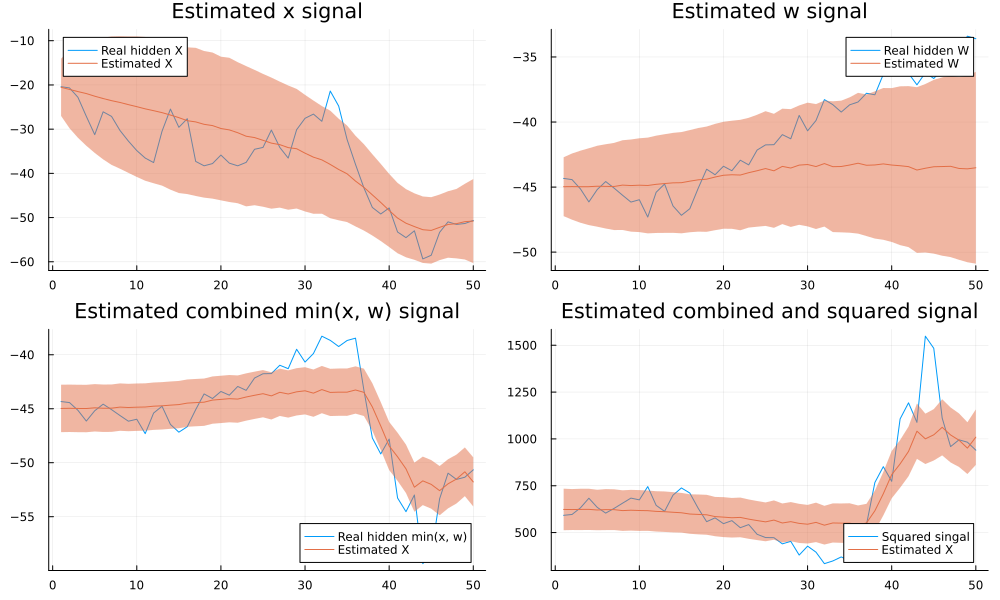

In [185]:
τ_x_marginals = result.posteriors[:τ_x]
τ_w_marginals = result.posteriors[:τ_w]
τ_y_marginals = result.posteriors[:τ_y]

tmarginals = result.posteriors[:t]
smarginals = result.posteriors[:s]
xmarginals = result.posteriors[:x]
wmarginals = result.posteriors[:w];

pxx = plot(legend = :topleft, title = "Estimated x signal")
pxw = plot(legend = :topright, title = "Estimated w signal")
pxs = plot(legend = :bottomright, title = "Estimated combined min(x, w) signal")
pxt = plot(legend = :bottomright, title = "Estimated combined and squared signal")

pxx = plot!(pxx, real_x, label = "Real hidden X")
pxx = plot!(pxx, mean.(xmarginals[end]), ribbon = 2 * sqrt.(var.(xmarginals[end])), label = "Estimated X")

pxw = plot!(pxw, real_w, label = "Real hidden W")
pxw = plot!(pxw, mean.(wmarginals[end]), ribbon = 2 * sqrt.(var.(wmarginals[end])), label = "Estimated W")

pxs = plot!(pxs, real_f, label = "Real hidden min(x, w)")
pxs = plot!(pxs, mean.(smarginals[end]), ribbon = 2 * sqrt.(var.(smarginals[end])), label = "Estimated X")

pxt = plot!(pxt, real_g, label = "Squared singal")
pxt = plot!(pxt, mean.(tmarginals[end]), ribbon = 2 * sqrt.(var.(tmarginals[end])), label = "Estimated X")

plot(pxx, pxw, pxs, pxt, size = (1000, 600))